In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set(font_scale=1.2)

np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'B01'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

In [3]:
time_window = 100
time_step = 100
trial_average = 8
n_splits = 30
group_dict = {0:[11,13],1:[21,23]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
wrangl.num_labels = 2
clfr = decode_eeg.Classification(wrangl,exp.nsub)

In [4]:
def grab_trials(xdata,ydata,beh,lower,width=5):
    upper = lower+width
    trial_idx = (beh['Trial'] >= lower) & (beh['Trial'] < upper)
    X_train_all, y_train, X_test_all, y_test = xdata[trial_idx], ydata[trial_idx], xdata[~trial_idx], ydata[~trial_idx]
    return X_train_all, y_train, X_test_all, y_test

In [5]:
# clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,2))
trials = np.arange(0,87,4)
conf_scores = np.empty((exp.nsub,len(trials),len(wrangl.t),wrangl.n_splits,2))
clfr.acc = np.zeros((clfr.nsub,len(trials),np.size(clfr.t),clfr.n_splits))*np.nan

for isub in range(exp.nsub):
    print(isub)
    xdata_all,ydata_all = exp.load_eeg(isub)
    beh=exp.load_behavior(isub)

    for itrial, trial in enumerate(trials):

        xdata, ydata, _, _ = grab_trials(xdata_all,ydata_all,beh,lower=trial,width=15)
        xdata,ydata = wrangl.setup_data(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                # if wrangl.itime != 28:
                #     continue
                # clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
                
                X_train, X_test = clfr.standardize(X_train, X_test)
        
                clfr.classifier.fit(X_train, y_train)

                clfr.acc[isub,itrial,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test)
                
                # get confidence of classification for each trial bin. >0 means orientation predicted.
                confidence_scores = clfr.classifier.decision_function(X_test)
                for i in set(y_test):
                    # clfr.confidence_scores[isub,itrial,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==i])
                    conf_scores[isub,itrial,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==i])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [6]:
from copy import deepcopy
cs = deepcopy(conf_scores)
cs[:,:,:,:,0] = cs[:,:,:,:,0]*-1

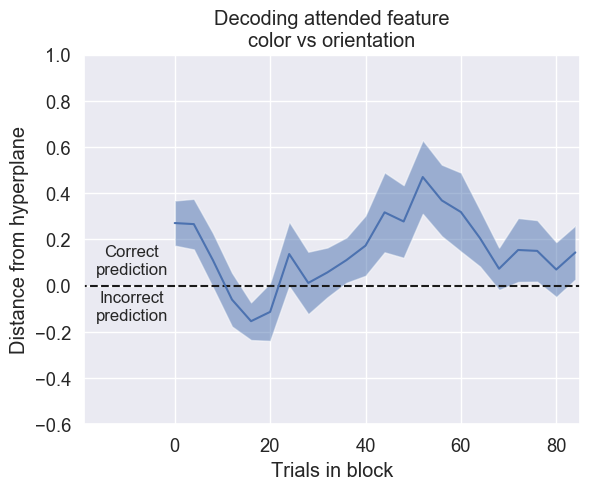

In [9]:
a = np.mean(np.mean(np.mean(cs,4),3)[:,:,wrangl.t>200],2)
med, upper, lower = get_plot_line(a)
plt.plot(np.arange(-20,100),np.zeros(120),'--',color='k')

plt.plot(trials,med)
plt.fill_between(trials,upper,lower,alpha=.5)
# for i in range(a.shape[0]):
#     plt.plot(trials,a[i],color='grey',linewidth=.3)
plt.ylim([-.6,1])
plt.xlim([-19,85])
plt.xlabel('Trials in block')
plt.ylabel('Distance from hyperplane')
plt.title('Decoding attended feature\ncolor vs orientation')

plt.text(-9,.05,'Correct\nprediction',fontsize=12,ha='center')
plt.text(-9,-.15,'Incorrect\nprediction',fontsize=12,ha='center')

plt.savefig('output/figures/hyperplane_block.png',dpi=500,bbox_inches='tight')
plt.show()


In [10]:
for isub in range(exp.nsub):
    if isub == 0:
        all_beh=pd.DataFrame(exp.load_behavior(isub))
    else:
        beh=pd.DataFrame(exp.load_behavior(isub))
        all_beh = all_beh.append(beh,ignore_index=True)


In [11]:
acc_gb = all_beh.groupby(['Subject','Trial'])['ACC'].mean().reset_index()
acc_mean = acc_gb.groupby('Trial')['ACC'].mean()
acc_sem = acc_gb.groupby('Trial')['ACC'].sem()

In [12]:
from scipy.ndimage.filters import uniform_filter1d
acc_rolling_mean = uniform_filter1d(acc_mean,size=20,mode='nearest')

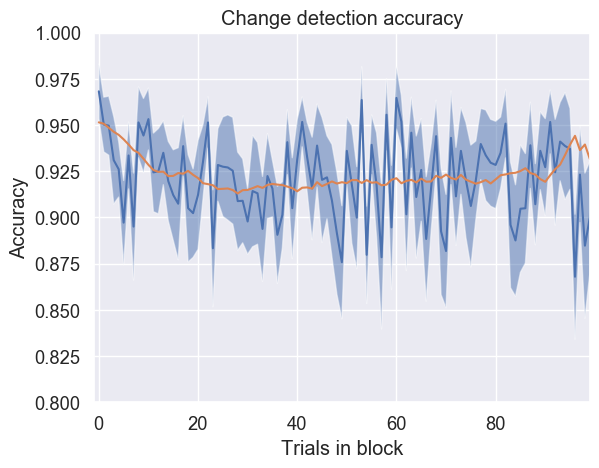

In [13]:
upper = acc_mean+acc_sem
lower = acc_mean-acc_sem
plt.plot(range(len(acc_mean)),acc_mean)
plt.plot(range(len(acc_rolling_mean)),acc_rolling_mean)


plt.fill_between(range(len(acc_mean)),upper,lower,alpha=.5)
# for i in range(a.shape[0]):
#     plt.plot(trials,a[i],color='grey',linewidth=.5)
plt.xlim(-1,99)
plt.ylim(.8,1)
plt.xlabel('Trials in block')
plt.ylabel('Accuracy')
plt.title('Change detection accuracy')
# plt.savefig('output/figures/beh_acc.png',dpi=500,bbox_inches='tight')
plt.show()


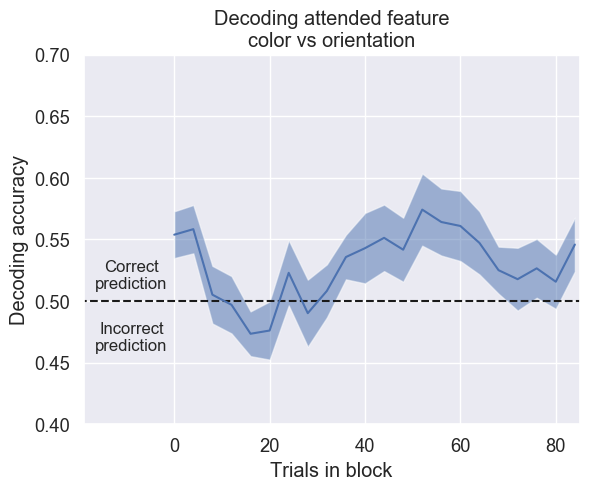

In [14]:
a = np.mean(np.mean(clfr.acc,3)[:,:,wrangl.t>200],2)
med, upper, lower = get_plot_line(a)
plt.plot(np.arange(-20,100),np.ones(120)*.5,'--',color='k')

plt.plot(trials,med)
plt.fill_between(trials,upper,lower,alpha=.5)
# for i in range(a.shape[0]):
#     plt.plot(trials,a[i],color='grey',linewidth=.5)

plt.ylim([.4,.7])
plt.xlim([-19,85])
plt.xlabel('Trials in block')
plt.ylabel('Decoding accuracy')
plt.title('Decoding attended feature\ncolor vs orientation')

plt.text(-9,.51,'Correct\nprediction',fontsize=12,ha='center')
plt.text(-9,.46,'Incorrect\nprediction',fontsize=12,ha='center')

plt.savefig('output/figures/acc_block.png',dpi=500,bbox_inches='tight')
plt.show()


In [8]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a,0)
    sem = sista.sem(a,0)
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower
import scipy.stats as sista

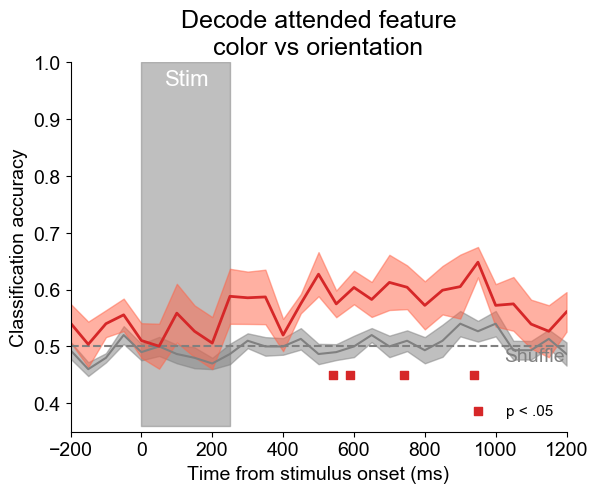

Significant timepoints: [550 600 750 950]
Mean delay accuracy: 0.5826705653021442
Mean delay S.D.: 0.03135212017201486


In [ ]:
interp = decode_eeg.Interpreter(clfr)
interp.labels = [1,2]
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.35,1],chance_text_y=.23, title='Decode attended feature\ncolor vs orientation')